In [1]:
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.patches import Ellipse
import matplotlib.lines as lines
from matplotlib import cm
import numpy as np

from sqlalchemy import create_engine, event
import urllib.parse

import seaborn as sns
sns.set()



# Inputs & Outputs

In [2]:
# SQL database
server = 'CSKMA0400\RDB_Data'
db = 'JLDJobPath'
odbc_connection_string = 'DRIVER={SQL Server Native Client 11.0};SERVER='+server+';DATABASE='+db+';Trusted_Connection=yes'

#Input Tables
flatjld_sql_table = "linkedclaims_casuals_2018m04_v2_flat_20161001_with_income"
clusters_sql_table = "linkedclaims_casuals_2018m04_v2_flat_20161001_with_income_36Vars__7BGM_full_clusters"
fimportance_sql_table = "linkedclaims_casuals_2018m04_v2_flat_multi_with_income_36Vars__7BGM_full_clusters_FeatImportance"

# Provide variables profile file
varprofile_csvfilename = "D:/DATA/" + flatjld_sql_table + "_variable_profile.csv"
varprofile_csvfilename = "D:/DATA/linkedclaims_casuals_2018m04_v2_flat_20140101_with_income_with_edu_variable_profile.csv"


# Set to TRUE if you want to 
# normalise variables counting levels with name starting with 'total_duration_days_'
# by variable 'total_duration_days' -- Note: make sure the variables are selected in the variable profile csv file
do_normalize_total_day_counts = True
drop_normalisation_column = True

# Set to TRUE if you want to 
# sum columns and update accordingly the list of lists below, 
# eg Col_A + Col_B and Col_B + Col_C + Col_D: [[Col_A, Col_B], [Col_B, Col_C, Col_D]]
do_sum_columns = False
columns_to_sum = [['Class_A_Earn0','Class_S_Earn0','Class_Other_Earn0'],
                  ['Class_A_Earn1','Class_S_Earn1','Class_Other_Earn1'],
                  ['Class_A_Earn2','Class_S_Earn2','Class_Other_Earn2'],
                  ['Class_A_Earn3','Class_S_Earn3','Class_Other_Earn3'],
                  ['Class_A_Earn4','Class_S_Earn4','Class_Other_Earn4']
                  ]
drop_original_cols = False # Set this to TRUE if you want to drop the cols summed

# Set to TRUE if you want to 
# divide columns and update accordingly the list of lists below, 
# eg Col_A/Col_B and Col_B/Col_C/Col_D: [[Col_A, Col_B], [Col_B, Col_C, Col_D]]
do_divide_columns = True
columns_to_divide = [['Class_A_Earn0','Class_A_weeks0'], 
                     ['Class_A_Earn1','Class_A_weeks1'],
                     ['Class_A_Earn2','Class_A_weeks2'],
                     ['Class_A_Earn3','Class_A_weeks3'], 
                     ['Class_A_Earn4','Class_A_weeks4']]
drop_nominator = True     # Set to TRUE if you want to drop the nominator cols
drop_denominator = False  # Set to TRUE if you want to drop the denominator cols

# Output
path="C:/Users/MarcoGrimaldi/AnacondaProjects/Analysis/MultiSampleFlatJLD/"
filename_overview = clusters_sql_table + '- 2 Population Profiling by Cluster_overview.png'
filename_profile = clusters_sql_table + '- 2 Population Profiling by Cluster_profile.png'

# Procedure

Read Data from SQL
Normalizing
Dividing Cols
Merging cluster info into dataset


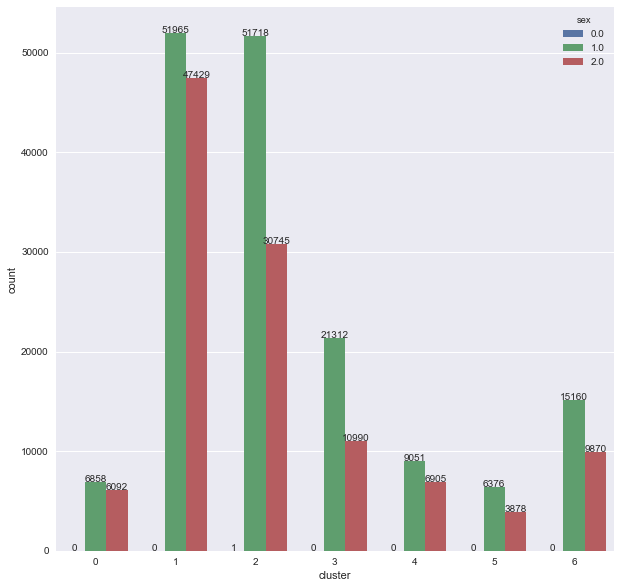

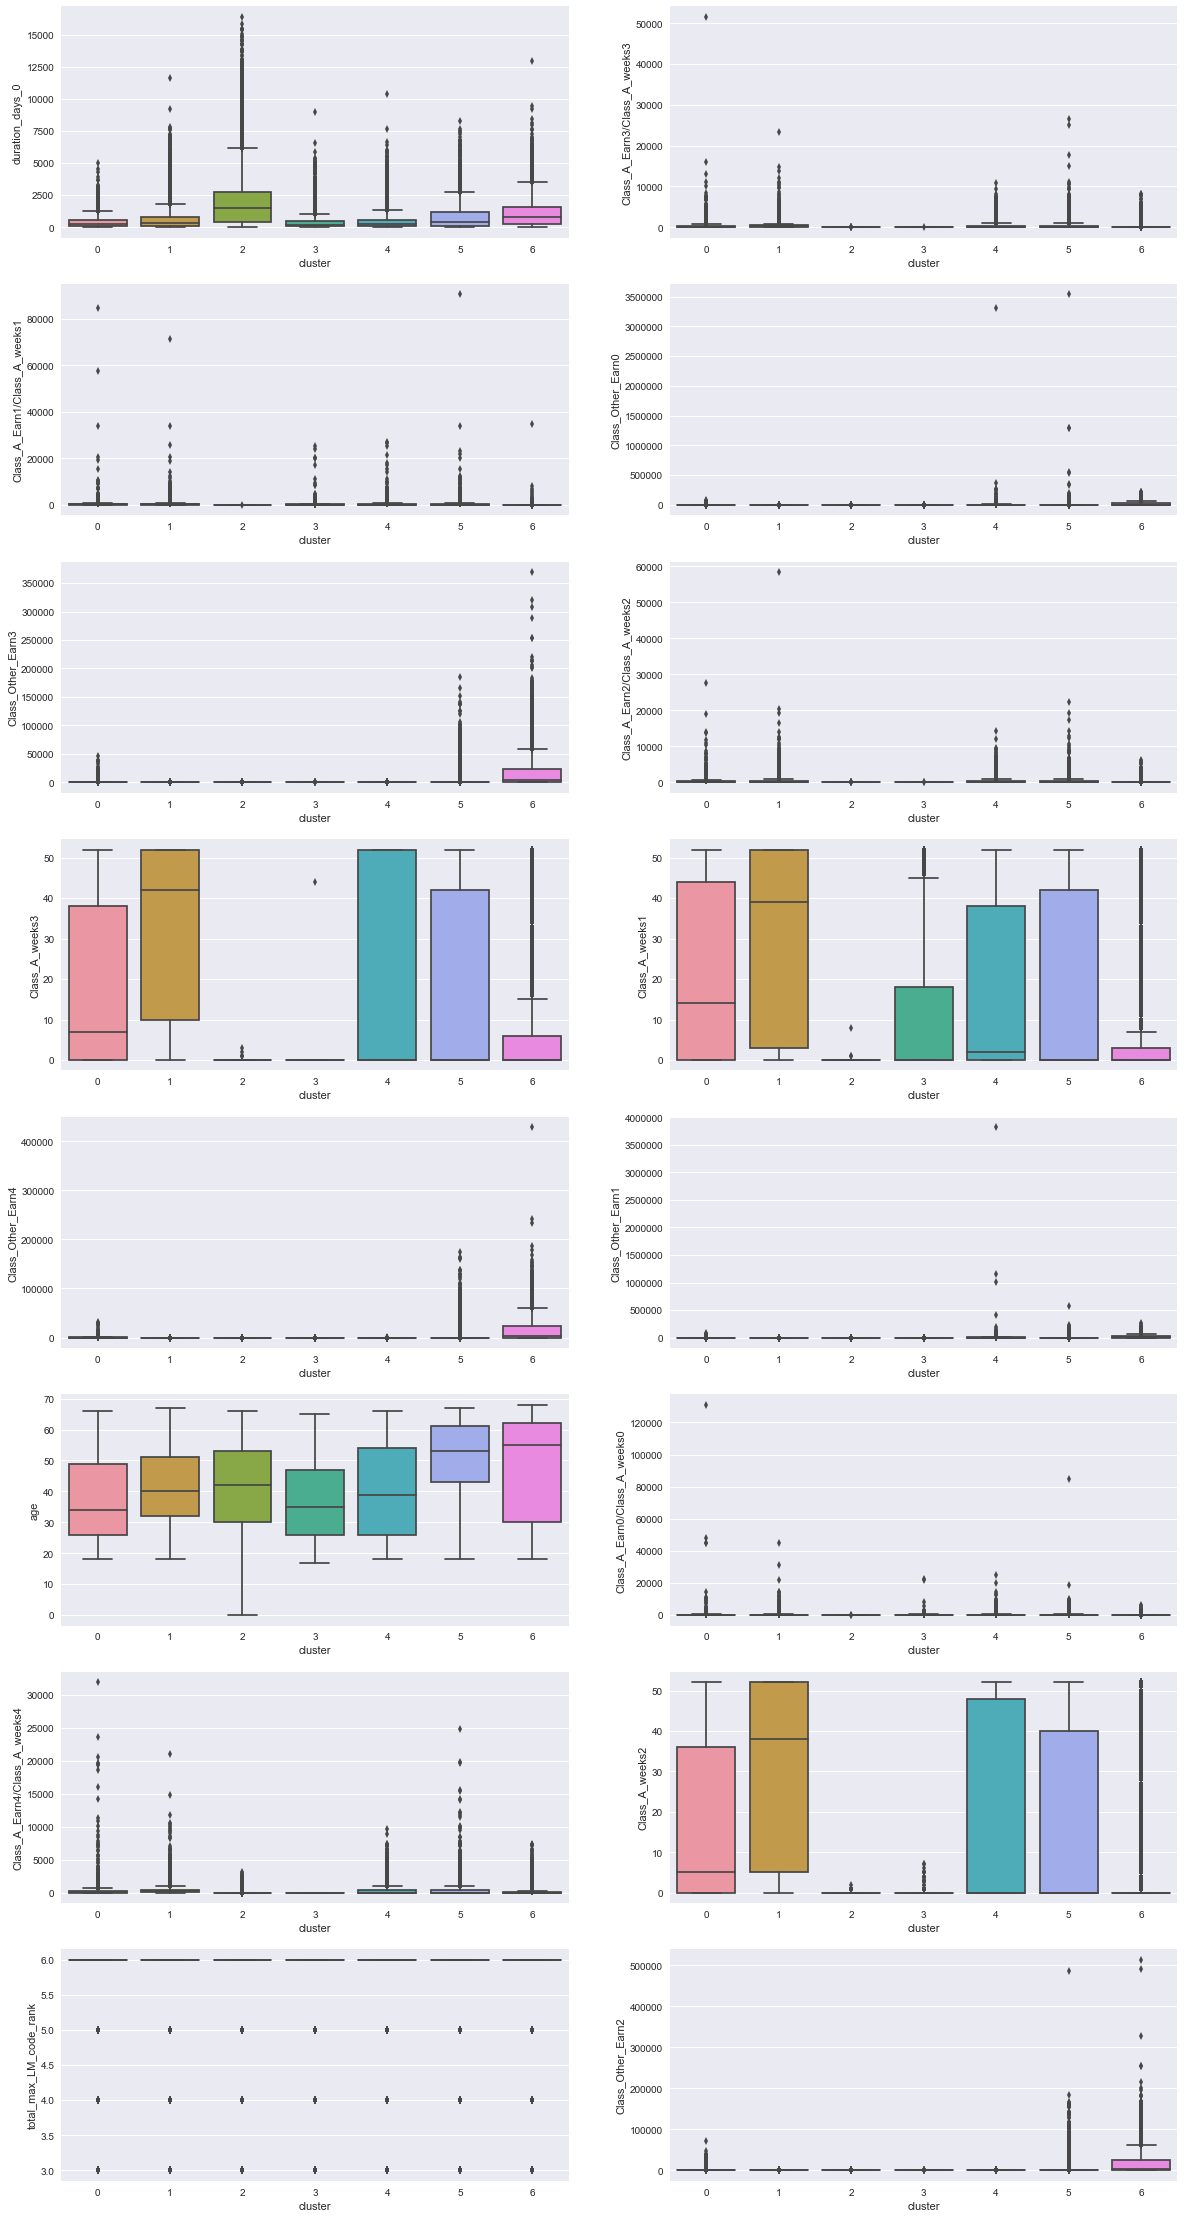

In [3]:
def read_data_from_sql(sql_table):
    # Connect to SQL
    params = urllib.parse.quote_plus(odbc_connection_string)
    engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
    conn = engine.connect().connection

    @event.listens_for(engine, 'before_cursor_execute')
    def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
        if executemany:
            cursor.fast_executemany = True

    df = pd.read_sql_table(sql_table, engine)
    conn.close()
    return df


def normalize_total_day_counts(df, drop_norm_col = False):
    col_names = df.columns.tolist()
    name_needle = 'total_duration_days_'
    norm_col = 'total_duration_days'

    for col in col_names:
        if name_needle in col:
            df[col] = df[col] / (df[norm_col]+1)
    
    if drop_norm_col == True:
        df.drop(columns=[norm_col], inplace=True)
    return df

def sum_columns(df, columns_to_sum, drop_original_cols = False):
    for columns in columns_to_sum:
        cols_in_dataset = True
        for col in columns:
            if col not in df.columns.tolist():
                cols_in_dataset = False
        if cols_in_dataset:
            myname = '+'.join(columns)
            df[myname] = df[columns[0]]
            for i in range(1, len(columns)):
                df[myname] = df[myname] + df[columns[i]]
    if drop_original_cols:
        to_drop = []
        for columns in columns_to_sum:
            for col in columns:
                to_drop.append(col)
        df.drop(columns=to_drop, inplace=True)

def divide_columns(df, columns_to_divide, drop_nominator = True, drop_denominator = False):
    for columns in columns_to_divide:
        cols_in_dataset = True
        for col in columns:
            if col not in df.columns.tolist():
                cols_in_dataset = False
        if cols_in_dataset:
            myname = '/'.join(columns)
            df[myname] = df[columns[0]]
            for i in range(1, len(columns)):
                df[myname] = df[myname] / (df[columns[i]] +1)
    
    cols_to_drop = []
    if drop_nominator:
        for cols in columns_to_divide:
            cols_to_drop.append(cols[0])
    if drop_denominator:
        for cols in columns_to_divide:
            cols_to_drop.append(cols[1])
    if len(cols_to_drop) > 0:
        df.drop(columns=cols_to_drop, inplace=True)

print ("Read Data from SQL")
flatjld = read_data_from_sql(flatjld_sql_table)
clusters = read_data_from_sql(clusters_sql_table)
fimportance = read_data_from_sql(fimportance_sql_table)

# # filling NA with 0
flatjld.fillna(0, inplace=True)

# Variables Normalization (Total Day Counts)
if do_normalize_total_day_counts:
    print ("Normalizing")
    flatjld = normalize_total_day_counts(flatjld, drop_normalisation_column)
if do_sum_columns:
    print ("Summing Cols")
    sum_columns(flatjld, columns_to_sum, drop_original_cols)
if do_divide_columns:
    print ("Dividing Cols")
    divide_columns(flatjld, columns_to_divide, drop_nominator, drop_denominator)

# Merge flat_jld with clustering info
print ("Merging cluster info into dataset")
flatjld = pd.merge(flatjld, clusters, on='ppsn', how='left')


varprofile = pd.read_csv(varprofile_csvfilename)

ax = sns.countplot(x="cluster", hue="sex", data=flatjld)
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        height = 0
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            str(int(height)),
            ha="center") 
fig = ax.get_figure()
fig.set_size_inches(10,10)
fig.savefig(path+filename_overview)

def plot_population_profile_by_clusters(data = None, varprofile = None, fimportance = None,ascendingimp = False, nplots=10, myfigsize = 20):
    if nplots is not None:
        if nplots > len(data.columns.tolist()) -2:
            nplots = len(data.columns.tolist()) -2
    else:
        nplots = len(data.columns.tolist()) -2
    
    dim = (nplots,1)
    if nplots % 3 == 0:
        dim = (int(nplots/3), 3) 
    elif nplots % 2 == 0:
        dim = (int(nplots/2), 2)

    xsize = myfigsize
    ysize = myfigsize*dim[1]
    fig, axarr = plt.subplots(dim[0],dim[1],figsize=(xsize,ysize)) 
    
    variables_to_plot = [data.columns.tolist()[i] for i in range(nplots+1)]
    if fimportance is not None:
        all_vars = data.columns.tolist()
        vars_with_importance = fimportance.FeatureName.tolist()
        missing_vars = [var for var in all_vars if var not in vars_with_importance]
        for var in missing_vars:
            mydf = pd.DataFrame()
            mydf['FeatureName'] = [var]
            mydf['MeanImportance'] = [0.0]
            fimportance = fimportance.append(mydf, ignore_index=True)
        variables_to_plot = fimportance.sort_values(by='MeanImportance', ascending=ascendingimp)['FeatureName'].tolist()
        variables_to_plot = variables_to_plot[0:nplots+1]
        
    n_clusters = data.cluster.unique()
    
    for row in range(dim[0]):
        for col in range(dim[1]):
                
            i = row * dim[1] + col
            
            my_axrr = axarr
            if dim[1] == 1 and dim[0] > 1:
                my_axrr = axarr[row]
            elif dim[0] == 1 and dim[1] > 1:
                my_axrr = axarr[col]
            elif dim[0] > 1 and dim[1] > 1:
                my_axrr = axarr[row,col]
                
            mytype = 'Num'
            try:
                mytype = varprofile.loc[varprofile.Variable == variables_to_plot[i],'Type'].tolist()[0]
            except:
                mytype = 'Num'
                
            if mytype == 'Num':
                ret = sns.boxplot(data=data, x = 'cluster', y = variables_to_plot[i], ax=my_axrr )
            
                    
        
    return fig

myplot = plot_population_profile_by_clusters(data = flatjld, varprofile = varprofile, \
                                             fimportance = fimportance, ascendingimp = False, nplots=16)
myplot.savefig(path+filename_profile)